In [70]:
import os
import gc
import numpy as np
import pandas as pd
import multiprocessing as mp
from scipy.stats import kurtosis
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, KFold
import xgboost as xgb
from xgboost import XGBClassifier
from functools import partial
from sklearn.ensemble import RandomForestClassifier
import lightgbm as lgb
warnings.simplefilter(action='ignore', category=FutureWarning)

In [71]:
df_train = pd.read_csv("/content/drive/MyDrive/loan/application_train.csv")
df_test = pd.read_csv("/content/drive/MyDrive/loan/application_test.csv")
df = df_train.append(df_test)
del df_train, df_test; gc.collect()

39

In [72]:
df.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,...,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1.0,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,351000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.018801,-9461,-637,-3648.0,-2120,NaN,1,1,0,1,1,0,Laborers,1.0,2,2,WEDNESDAY,10,0,0,0,0,0,0,...,0.0205,0.0193,0.0000,0.00,reg oper account,block of flats,0.0149,"Stone, brick",No,2.0,2.0,2.0,2.0,-1134.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0.0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,1129500.0,Family,State servant,Higher education,Married,House / apartment,0.003541,-16765,-1188,-1186.0,-291,NaN,1,1,0,1,1,0,Core staff,2.0,1,1,MONDAY,11,0,0,0,0,0,0,...,0.0787,0.0558,0.0039,0.01,reg oper account,block of flats,0.0714,Block,No,1.0,0.0,1.0,0.0,-828.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0.0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,135000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.010032,-19046,-225,-4260.0,-2531,26.0,1,1,1,1,1,0,Laborers,1.0,2,2,MONDAY,9,0,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,-815.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0.0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,297000.0,Unaccompanied,Working,Secondary / secondary special,Civil marriage,House / apartment,0.008019,-19005,-3039,-9833.0,-2437,NaN,1,1,0,1,0,0,Laborers,2.0,2,2,WEDNESDAY,17,0,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,0.0,2.0,0.0,-617.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0.0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,513000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.028663,-19932,-3038,-4311.0,-3458,NaN,1,1,0,1,0,0,Core staff,1.0,2,2,THURSDAY,11,0,0,0,0,1,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,-1106.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 347614 entries, 0 to 48743
Columns: 106 entries, SK_ID_CURR to AMT_REQ_CREDIT_BUREAU_YEAR
dtypes: float64(86), int64(20)
memory usage: 283.8 MB


In [ ]:
df_cat_1 = df.select_dtypes(include=['object']).copy()

In [ ]:
df_cat_1.head()

,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,OCCUPATION_TYPE,WEEKDAY_APPR_PROCESS_START,ORGANIZATION_TYPE,FONDKAPREMONT_MODE,HOUSETYPE_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE
0,Cash loans,M,N,Y,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,Laborers,WEDNESDAY,Business Entity Type 3,reg oper account,block of flats,"Stone, brick",No
1,Cash loans,F,N,N,Family,State servant,Higher education,Married,House / apartment,Core staff,MONDAY,School,reg oper account,block of flats,Block,No
2,Revolving loans,M,Y,Y,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,Laborers,MONDAY,Government,NaN,NaN,NaN,NaN
3,Cash loans,F,N,Y,Unaccompanied,Working,Secondary / secondary special,Civil marriage,House / apartment,Laborers,WEDNESDAY,Business Entity Type 3,NaN,NaN,NaN,NaN
4,Cash loans,M,N,Y,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,Core staff,THURSDAY,Religion,NaN,NaN,NaN,NaN


In [ ]:
df_cat_1.to_csv('/content/drive/MyDrive/loan/train+test_1.csv', index = False)

In [ ]:
df=df.drop(['NAME_CONTRACT_TYPE', 'CODE_GENDER','FLAG_OWN_CAR','FLAG_OWN_REALTY','NAME_TYPE_SUITE','NAME_INCOME_TYPE','NAME_EDUCATION_TYPE','NAME_FAMILY_STATUS','NAME_HOUSING_TYPE','OCCUPATION_TYPE','WEEKDAY_APPR_PROCESS_START','ORGANIZATION_TYPE','FONDKAPREMONT_MODE','HOUSETYPE_MODE','WALLSMATERIAL_MODE','EMERGENCYSTATE_MODE'], axis = 1)

In [ ]:
df.head()

,SK_ID_CURR,TARGET,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,...,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,TOTALAREA_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1.0,0,202500.0,406597.5,24700.5,351000.0,0.018801,-9461,-637,-3648.0,-2120,NaN,1,1,0,1,1,0,1.0,2,2,10,0,0,0,0,0,0,0.083037,0.262949,0.139376,0.0247,0.0369,0.9722,0.6192,0.0143,0.00,0.0690,0.0833,...,0.0690,0.0833,0.1250,0.0375,0.0205,0.0193,0.0000,0.00,0.0149,2.0,2.0,2.0,2.0,-1134.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0.0,0,270000.0,1293502.5,35698.5,1129500.0,0.003541,-16765,-1188,-1186.0,-291,NaN,1,1,0,1,1,0,2.0,1,1,11,0,0,0,0,0,0,0.311267,0.622246,NaN,0.0959,0.0529,0.9851,0.7960,0.0605,0.08,0.0345,0.2917,...,0.0345,0.2917,0.3333,0.0132,0.0787,0.0558,0.0039,0.01,0.0714,1.0,0.0,1.0,0.0,-828.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0.0,0,67500.0,135000.0,6750.0,135000.0,0.010032,-19046,-225,-4260.0,-2531,26.0,1,1,1,1,1,0,1.0,2,2,9,0,0,0,0,0,0,NaN,0.555912,0.729567,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,-815.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0.0,0,135000.0,312682.5,29686.5,297000.0,0.008019,-19005,-3039,-9833.0,-2437,NaN,1,1,0,1,0,0,2.0,2,2,17,0,0,0,0,0,0,NaN,0.650442,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,0.0,2.0,0.0,-617.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0.0,0,121500.0,513000.0,21865.5,513000.0,0.028663,-19932,-3038,-4311.0,-3458,NaN,1,1,0,1,0,0,1.0,2,2,11,0,0,0,0,1,1,NaN,0.322738,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,-1106.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:

df = df[df['AMT_INCOME_TOTAL'] < 20000000]
df['DAYS_EMPLOYED'].replace(365243, np.nan, inplace=True)
df['DAYS_LAST_PHONE_CHANGE'].replace(0, np.nan, inplace=True)

In [ ]:
def get_age_group(days_birth):
    age_years = -days_birth / 365
    if age_years < 27: return 1
    elif age_years < 40: return 2
    elif age_years < 50: return 3
    elif age_years < 65: return 4
    elif age_years < 99: return 5
    else: return 0

In [ ]:
docs = [f for f in df.columns if 'FLAG_DOC' in f]
df['DOCUMENT_COUNT'] = df[docs].sum(axis=1)
df['NEW_DOC_KURT'] = df[docs].kurtosis(axis=1)
df['AGE_RANGE'] = df['DAYS_BIRTH'].apply(lambda x: get_age_group(x))

In [ ]:

df['EXT_SOURCES_PROD'] = df['EXT_SOURCE_1'] * df['EXT_SOURCE_2'] * df['EXT_SOURCE_3']
df['EXT_SOURCES_WEIGHTED'] = df.EXT_SOURCE_1 * 2 + df.EXT_SOURCE_2 * 1 + df.EXT_SOURCE_3 * 3
np.warnings.filterwarnings('ignore', r'All-NaN (slice|axis) encountered')
for function_name in ['min', 'max', 'mean', 'nanmedian', 'var']:
    feature_name = 'EXT_SOURCES_{}'.format(function_name.upper())
    df[feature_name] = eval('np.{}'.format(function_name))(
        df[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']], axis=1)

In [ ]:

df['CREDIT_TO_ANNUITY_RATIO'] = df['AMT_CREDIT'] / df['AMT_ANNUITY']
df['CREDIT_TO_GOODS_RATIO'] = df['AMT_CREDIT'] / df['AMT_GOODS_PRICE']
df['ANNUITY_TO_INCOME_RATIO'] = df['AMT_ANNUITY'] / df['AMT_INCOME_TOTAL']
df['CREDIT_TO_INCOME_RATIO'] = df['AMT_CREDIT'] / df['AMT_INCOME_TOTAL']
df['INCOME_TO_EMPLOYED_RATIO'] = df['AMT_INCOME_TOTAL'] / df['DAYS_EMPLOYED']
df['INCOME_TO_BIRTH_RATIO'] = df['AMT_INCOME_TOTAL'] / df['DAYS_BIRTH']    
df['EMPLOYED_TO_BIRTH_RATIO'] = df['DAYS_EMPLOYED'] / df['DAYS_BIRTH']
df['ID_TO_BIRTH_RATIO'] = df['DAYS_ID_PUBLISH'] / df['DAYS_BIRTH']
df['CAR_TO_BIRTH_RATIO'] = df['OWN_CAR_AGE'] / df['DAYS_BIRTH']
df['CAR_TO_EMPLOYED_RATIO'] = df['OWN_CAR_AGE'] / df['DAYS_EMPLOYED']
df['PHONE_TO_BIRTH_RATIO'] = df['DAYS_LAST_PHONE_CHANGE'] / df['DAYS_BIRTH']

In [ ]:
def do_mean(df, group_cols, counted, agg_name):
    gp = df[group_cols + [counted]].groupby(group_cols)[counted].mean().reset_index().rename(
        columns={counted: agg_name})
    df = df.merge(gp, on=group_cols, how='left')
    del gp
    gc.collect()
    return df

In [ ]:
def do_median(df, group_cols, counted, agg_name):
    gp = df[group_cols + [counted]].groupby(group_cols)[counted].median().reset_index().rename(
        columns={counted: agg_name})
    df = df.merge(gp, on=group_cols, how='left')
    del gp
    gc.collect()
    return df

In [ ]:
def do_std(df, group_cols, counted, agg_name):
    gp = df[group_cols + [counted]].groupby(group_cols)[counted].std().reset_index().rename(
        columns={counted: agg_name})
    df = df.merge(gp, on=group_cols, how='left')
    del gp
    gc.collect()
    return df

In [ ]:
def do_sum(df, group_cols, counted, agg_name):
    gp = df[group_cols + [counted]].groupby(group_cols)[counted].sum().reset_index().rename(
        columns={counted: agg_name})
    df = df.merge(gp, on=group_cols, how='left')
    del gp
    gc.collect()
    return df

In [ ]:
group = ['AGE_RANGE']
df = do_median(df, group, 'EXT_SOURCES_MEAN', 'GROUP_EXT_SOURCES_MEDIAN')
df = do_std(df, group, 'EXT_SOURCES_MEAN', 'GROUP_EXT_SOURCES_STD')
df = do_mean(df, group, 'AMT_INCOME_TOTAL', 'GROUP_INCOME_MEAN')
df = do_std(df, group, 'AMT_INCOME_TOTAL', 'GROUP_INCOME_STD')
df = do_mean(df, group, 'CREDIT_TO_ANNUITY_RATIO', 'GROUP_CREDIT_TO_ANNUITY_MEAN')
df = do_std(df, group, 'CREDIT_TO_ANNUITY_RATIO', 'GROUP_CREDIT_TO_ANNUITY_STD')
df = do_mean(df, group, 'AMT_CREDIT', 'GROUP_CREDIT_MEAN')
df = do_mean(df, group, 'AMT_ANNUITY', 'GROUP_ANNUITY_MEAN')
df = do_std(df, group, 'AMT_ANNUITY', 'GROUP_ANNUITY_STD')

In [ ]:
def drop_application_columns(df):
    drop_list = [
        'CNT_CHILDREN', 'CNT_FAM_MEMBERS', 'HOUR_APPR_PROCESS_START',
        'FLAG_EMP_PHONE', 'FLAG_MOBIL', 'FLAG_CONT_MOBILE', 'FLAG_EMAIL', 'FLAG_PHONE',
         'REG_REGION_NOT_LIVE_REGION', 'REG_REGION_NOT_WORK_REGION',
        'REG_CITY_NOT_WORK_CITY', 'OBS_30_CNT_SOCIAL_CIRCLE', 'OBS_60_CNT_SOCIAL_CIRCLE',
        'AMT_REQ_CREDIT_BUREAU_DAY', 'AMT_REQ_CREDIT_BUREAU_MON', 'AMT_REQ_CREDIT_BUREAU_YEAR', 
        'COMMONAREA_MODE', 'NONLIVINGAREA_MODE', 'ELEVATORS_MODE', 'NONLIVINGAREA_AVG',
        'FLOORSMIN_MEDI', 'LANDAREA_MODE', 'NONLIVINGAREA_MEDI', 'LIVINGAPARTMENTS_MODE',
        'FLOORSMIN_AVG', 'LANDAREA_AVG', 'FLOORSMIN_MODE', 'LANDAREA_MEDI',
        'COMMONAREA_MEDI', 'YEARS_BUILD_AVG', 'COMMONAREA_AVG', 'BASEMENTAREA_AVG',
        'BASEMENTAREA_MODE', 'NONLIVINGAPARTMENTS_MEDI', 'BASEMENTAREA_MEDI', 
        'LIVINGAPARTMENTS_AVG', 'ELEVATORS_AVG', 'YEARS_BUILD_MEDI', 'ENTRANCES_MODE',
        'NONLIVINGAPARTMENTS_MODE', 'LIVINGAREA_MODE', 'LIVINGAPARTMENTS_MEDI',
        'YEARS_BUILD_MODE', 'YEARS_BEGINEXPLUATATION_AVG', 'ELEVATORS_MEDI', 'LIVINGAREA_MEDI',
        'YEARS_BEGINEXPLUATATION_MODE', 'NONLIVINGAPARTMENTS_AVG', 
      
    ]
    for doc_num in [2,4,5,6,7,9,10,11,12,13,14,15,16,17,19,20,21]:
        drop_list.append('FLAG_DOCUMENT_{}'.format(doc_num))
    df.drop(drop_list, axis=1, inplace=True)
    return df

In [ ]:
df.head()

,SK_ID_CURR,TARGET,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,DOCUMENT_COUNT,NEW_DOC_KURT,AGE_RANGE,EXT_SOURCES_PROD,EXT_SOURCES_WEIGHTED,EXT_SOURCES_MIN,EXT_SOURCES_MAX,EXT_SOURCES_MEAN,EXT_SOURCES_NANMEDIAN,EXT_SOURCES_VAR,CREDIT_TO_ANNUITY_RATIO,CREDIT_TO_GOODS_RATIO,ANNUITY_TO_INCOME_RATIO,CREDIT_TO_INCOME_RATIO,INCOME_TO_EMPLOYED_RATIO,INCOME_TO_BIRTH_RATIO,EMPLOYED_TO_BIRTH_RATIO,ID_TO_BIRTH_RATIO,CAR_TO_BIRTH_RATIO,CAR_TO_EMPLOYED_RATIO,PHONE_TO_BIRTH_RATIO,GROUP_EXT_SOURCES_MEDIAN,GROUP_EXT_SOURCES_STD,GROUP_INCOME_MEAN,GROUP_INCOME_STD,GROUP_CREDIT_TO_ANNUITY_MEAN,GROUP_CREDIT_TO_ANNUITY_STD,GROUP_CREDIT_MEAN,GROUP_ANNUITY_MEAN,GROUP_ANNUITY_STD
0,100002,1.0,0,202500.0,406597.5,24700.5,351000.0,0.018801,-9461,-637.0,-3648.0,-2120,NaN,1,1,0,1,1,0,1.0,2,2,10,0,0,0,0,0,0,0.083037,0.262949,0.139376,0.0247,0.0369,0.9722,0.6192,0.0143,0.00,0.0690,0.0833,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,20.0,1,0.003043,0.84715,0.083037,0.262949,0.161787,0.139376,0.005646,16.461104,1.158397,0.121978,2.007889,-317.896389,-21.403657,0.067329,0.224078,NaN,NaN,0.119860,0.392974,0.144344,152672.020861,75893.300832,18.547707,6.872720,434029.828339,23292.421316,13087.885806
1,100003,0.0,0,270000.0,1293502.5,35698.5,1129500.0,0.003541,-16765,-1188.0,-1186.0,-291,NaN,1,1,0,1,1,0,2.0,1,1,11,0,0,0,0,0,0,0.311267,0.622246,NaN,0.0959,0.0529,0.9851,0.7960,0.0605,0.08,0.0345,0.2917,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,20.0,3,NaN,NaN,0.311267,0.622246,0.466757,0.466757,0.024177,36.234085,1.145199,0.132217,4.790750,-227.272727,-16.104981,0.070862,0.017358,NaN,NaN,0.049389,0.548577,0.137487,182011.717164,125159.902984,21.765281,7.834100,646255.768751,29207.705583,15146.827732
2,100004,0.0,0,67500.0,135000.0,6750.0,135000.0,0.010032,-19046,-225.0,-4260.0,-2531,26.0,1,1,1,1,1,0,1.0,2,2,9,0,0,0,0,0,0,NaN,0.555912,0.729567,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4,NaN,NaN,0.555912,0.729567,0.642739,0.642739,0.007539,20.000000,1.000000,0.100000,2.000000,-300.000000,-3.544051,0.011814,0.132889,-0.001365,-0.115556,0.042791,0.569022,0.144111,160662.635515,98914.852803,22.422211,7.720913,619707.979469,27148.572738,14771.194262
3,100006,0.0,0,135000.0,312682.5,29686.5,297000.0,0.008019,-19005,-3039.0,-9833.0,-2437,NaN,1,1,0,1,0,0,2.0,2,2,17,0,0,0,0,0,0,NaN,0.650442,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,1.0,20.0,4,NaN,NaN,0.650442,0.650442,0.650442,0.650442,0.000000,10.532818,1.052803,0.219900,2.316167,-44.422507,-7.103394,0.159905,0.128229,NaN,NaN,0.032465,0.569022,0.144111,160662.635515,98914.852803,22.422211,7.720913,619707.979469,27148.572738,14771.194262
4,100007,0.0,0,121500.0,513000.0,21865.5,513000.0,0.028663,-19932,-3038.0,-4311.0,-3458,NaN,1,1,0,1,0,0,1.0,2,2,11,0,0,0,0,1,1,NaN,0.322738,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,20.0,4,NaN,NaN,0.322738,0.322738,0.322738,0.322738,0.000000,23.461618,1.000000,0.179963,4.222222,-39.993417,-6.095725,0.152418,0.173490,NaN,NaN,0.055489,0.569022,0.144111,160662.635515,98914.852803,22.422211,7.720913,619707.979469,27148.572738,14771.1942

In [ ]:
df = drop_application_columns(df)

In [ ]:

bureau = pd.read_csv("/content/drive/MyDrive/loan/bureau.csv")

In [ ]:
bureau.head()

,SK_ID_CURR,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY
0,215354,5714462,Closed,currency 1,-497,0,-153.0,-153.0,NaN,0,91323.0,0.0,NaN,0.0,Consumer credit,-131,NaN
1,215354,5714463,Active,currency 1,-208,0,1075.0,NaN,NaN,0,225000.0,171342.0,NaN,0.0,Credit card,-20,NaN
2,215354,5714464,Active,currency 1,-203,0,528.0,NaN,NaN,0,464323.5,NaN,NaN,0.0,Consumer credit,-16,NaN
3,215354,5714465,Active,currency 1,-203,0,NaN,NaN,NaN,0,90000.0,NaN,NaN,0.0,Credit card,-16,NaN
4,215354,5714466,Active,currency 1,-629,0,1197.0,NaN,77674.5,0,2700000.0,NaN,NaN,0.0,Consumer credit,-21,NaN


In [ ]:
bureau.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1716428 entries, 0 to 1716427
Data columns (total 17 columns):
 #   Column                  Dtype  
---  ------                  -----  
 0   SK_ID_CURR              int64  
 1   SK_ID_BUREAU            int64  
 2   CREDIT_ACTIVE           object 
 3   CREDIT_CURRENCY         object 
 4   DAYS_CREDIT             int64  
 5   CREDIT_DAY_OVERDUE      int64  
 6   DAYS_CREDIT_ENDDATE     float64
 7   DAYS_ENDDATE_FACT       float64
 8   AMT_CREDIT_MAX_OVERDUE  float64
 9   CNT_CREDIT_PROLONG      int64  
 10  AMT_CREDIT_SUM          float64
 11  AMT_CREDIT_SUM_DEBT     float64
 12  AMT_CREDIT_SUM_LIMIT    float64
 13  AMT_CREDIT_SUM_OVERDUE  float64
 14  CREDIT_TYPE             object 
 15  DAYS_CREDIT_UPDATE      int64  
 16  AMT_ANNUITY             float64
dtypes: float64(8), int64(6), object(3)
memory usage: 222.6+ MB


In [ ]:
bureau_cat = bureau.select_dtypes(include=['object']).copy()

In [ ]:
bureau_cat.to_csv('/content/drive/MyDrive/loan/bureau_cat_2.csv', index = False)

In [ ]:
bureau=bureau.drop(['CREDIT_TYPE','CREDIT_CURRENCY','CREDIT_ACTIVE'], axis = 1)

In [ ]:

bureau['CREDIT_DURATION'] = -bureau['DAYS_CREDIT'] + bureau['DAYS_CREDIT_ENDDATE']
bureau['ENDDATE_DIF'] = bureau['DAYS_CREDIT_ENDDATE'] - bureau['DAYS_ENDDATE_FACT']
bureau['DEBT_PERCENTAGE'] = bureau['AMT_CREDIT_SUM'] / bureau['AMT_CREDIT_SUM_DEBT']
bureau['DEBT_CREDIT_DIFF'] = bureau['AMT_CREDIT_SUM'] - bureau['AMT_CREDIT_SUM_DEBT']
bureau['CREDIT_TO_ANNUITY_RATIO'] = bureau['AMT_CREDIT_SUM'] / bureau['AMT_ANNUITY']

In [ ]:
def group(df_to_agg, prefix, aggregations, aggregate_by= 'SK_ID_CURR'):
    agg_df = df_to_agg.groupby(aggregate_by).agg(aggregations)
    agg_df.columns = pd.Index(['{}{}_{}'.format(prefix, e[0], e[1].upper())
                               for e in agg_df.columns.tolist()])
    return agg_df.reset_index()

In [ ]:
def group_and_merge(df_to_agg, df_to_merge, prefix, aggregations, aggregate_by= 'SK_ID_CURR'):
    agg_df = group(df_to_agg, prefix, aggregations, aggregate_by= aggregate_by)
    return df_to_merge.merge(agg_df, how='left', on= aggregate_by)

In [ ]:
def get_bureau_balance(path, num_rows= None):
    bb = pd.read_csv(os.path.join(path, 'bureau_balance.csv'))
    bb_processed = bb.groupby('SK_ID_BUREAU').mean().reset_index()
    agg = {'MONTHS_BALANCE': ['min', 'max', 'mean', 'size']}
    bb_processed = group_and_merge(bb, bb_processed, '', agg, 'SK_ID_BUREAU')
    del bb; gc.collect()
    return bb_processed

In [ ]:
bureau = bureau.merge(get_bureau_balance("/content/drive/MyDrive/loan"), how='left', on='SK_ID_BUREAU')
bureau['STATUS_12345'] = 0


In [ ]:
features = ['AMT_CREDIT_MAX_OVERDUE', 'AMT_CREDIT_SUM_OVERDUE', 'AMT_CREDIT_SUM',
    'AMT_CREDIT_SUM_DEBT', 'DEBT_PERCENTAGE', 'DEBT_CREDIT_DIFF', 'STATUS_12345']


In [ ]:
BUREAU_AGG = {
    'SK_ID_BUREAU': ['nunique'],
    'DAYS_CREDIT': ['min', 'max', 'mean'],
    'DAYS_CREDIT_ENDDATE': ['min', 'max'],
    'AMT_CREDIT_MAX_OVERDUE': ['max', 'mean'],
    'AMT_CREDIT_SUM': ['max', 'mean', 'sum'],
    'AMT_CREDIT_SUM_DEBT': ['max', 'mean', 'sum'],
    'AMT_CREDIT_SUM_OVERDUE': ['max', 'mean', 'sum'],
    'AMT_ANNUITY': ['mean'],
    'DEBT_CREDIT_DIFF': ['mean', 'sum'],
    'STATUS_12345': ['mean'],
}

BUREAU_ACTIVE_AGG = {
    'DAYS_CREDIT': ['max', 'mean'],
    'DAYS_CREDIT_ENDDATE': ['min', 'max'],
    'AMT_CREDIT_MAX_OVERDUE': ['max', 'mean'],
    'AMT_CREDIT_SUM': ['max', 'sum'],
    'AMT_CREDIT_SUM_DEBT': ['mean', 'sum'],
    'AMT_CREDIT_SUM_OVERDUE': ['max', 'mean'],
    'DAYS_CREDIT_UPDATE': ['min', 'mean'],
    'DEBT_PERCENTAGE': ['mean'],
    'DEBT_CREDIT_DIFF': ['mean'],
    'CREDIT_TO_ANNUITY_RATIO': ['mean'],
}

BUREAU_CLOSED_AGG = {
    'DAYS_CREDIT': ['max', 'var'],
    'DAYS_CREDIT_ENDDATE': ['max'],
    'AMT_CREDIT_MAX_OVERDUE': ['max', 'mean'],
    'AMT_CREDIT_SUM_OVERDUE': ['mean'],
    'AMT_CREDIT_SUM': ['max', 'mean', 'sum'],
    'AMT_CREDIT_SUM_DEBT': ['max', 'sum'],
    'DAYS_CREDIT_UPDATE': ['max'],
    'ENDDATE_DIF': ['mean'],
    'STATUS_12345': ['mean'],
}

BUREAU_LOAN_TYPE_AGG = {
    'DAYS_CREDIT': ['mean', 'max'],
    'AMT_CREDIT_MAX_OVERDUE': ['mean', 'max'],
    'AMT_CREDIT_SUM': ['mean', 'max'],
    'AMT_CREDIT_SUM_DEBT': ['mean', 'max'],
    'DEBT_PERCENTAGE': ['mean'],
    'DEBT_CREDIT_DIFF': ['mean'],
    'DAYS_CREDIT_ENDDATE': ['max'],
}

BUREAU_TIME_AGG = {
    'AMT_CREDIT_MAX_OVERDUE': ['max', 'mean'],
    'AMT_CREDIT_SUM_OVERDUE': ['mean'],
    'AMT_CREDIT_SUM': ['max', 'sum'],
    'AMT_CREDIT_SUM_DEBT': ['mean', 'sum'],
    'DEBT_PERCENTAGE': ['mean'],
    'DEBT_CREDIT_DIFF': ['mean'],
    'STATUS_12345': ['mean'],
}

In [ ]:
agg_bureau = group(bureau, 'BUREAU_', BUREAU_AGG)


for time_frame in [6, 12]:
    prefix = "BUREAU_LAST{}M_".format(time_frame)
    time_frame_df = bureau[bureau['DAYS_CREDIT'] >= -30*time_frame]
    agg_bureau = group_and_merge(time_frame_df, agg_bureau, prefix, BUREAU_TIME_AGG)
    del time_frame_df; gc.collect()

In [ ]:
sort_bureau = bureau.sort_values(by=['DAYS_CREDIT'])
gr = sort_bureau.groupby('SK_ID_CURR')['AMT_CREDIT_MAX_OVERDUE'].last().reset_index()
gr.rename({'AMT_CREDIT_MAX_OVERDUE': 'BUREAU_LAST_LOAN_MAX_OVERDUE'}, inplace=True)
agg_bureau = agg_bureau.merge(gr, on='SK_ID_CURR', how='left')


In [ ]:
df = pd.merge(df, agg_bureau, on='SK_ID_CURR', how='left')
del agg_bureau, bureau
gc.collect()

0

In [ ]:
prev = pd.read_csv("/content/drive/MyDrive/loan/previous_application.csv")
pay = pd.read_csv("/content/drive/MyDrive/loan/installments_payments.csv")

In [ ]:
prev.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1670214 entries, 0 to 1670213
Data columns (total 37 columns):
 #   Column                       Non-Null Count    Dtype  
---  ------                       --------------    -----  
 0   SK_ID_PREV                   1670214 non-null  int64  
 1   SK_ID_CURR                   1670214 non-null  int64  
 2   NAME_CONTRACT_TYPE           1670214 non-null  object 
 3   AMT_ANNUITY                  1297979 non-null  float64
 4   AMT_APPLICATION              1670214 non-null  float64
 5   AMT_CREDIT                   1670213 non-null  float64
 6   AMT_DOWN_PAYMENT             774370 non-null   float64
 7   AMT_GOODS_PRICE              1284699 non-null  float64
 8   WEEKDAY_APPR_PROCESS_START   1670214 non-null  object 
 9   HOUR_APPR_PROCESS_START      1670214 non-null  int64  
 10  FLAG_LAST_APPL_PER_CONTRACT  1670214 non-null  object 
 11  NFLAG_LAST_APPL_IN_DAY       1670214 non-null  int64  
 12  RATE_DOWN_PAYMENT            774370 non-nu

In [ ]:
prev_cat = prev.select_dtypes(include=['object']).copy()

In [ ]:
prev_cat.to_csv('/content/drive/MyDrive/loan/prev_cat_3.csv', index = False)

In [ ]:
prev=prev.drop(['NAME_CONTRACT_TYPE','WEEKDAY_APPR_PROCESS_START','FLAG_LAST_APPL_PER_CONTRACT','NAME_CASH_LOAN_PURPOSE','NAME_CONTRACT_STATUS','NAME_PAYMENT_TYPE','CODE_REJECT_REASON','NAME_TYPE_SUITE','NAME_CLIENT_TYPE','NAME_GOODS_CATEGORY','NAME_PORTFOLIO','NAME_PRODUCT_TYPE','CHANNEL_TYPE','NAME_SELLER_INDUSTRY','NAME_YIELD_GROUP','PRODUCT_COMBINATION'], axis = 1)

In [ ]:
PREVIOUS_AGG = {
    'SK_ID_PREV': ['nunique'],
    'AMT_ANNUITY': ['min', 'max', 'mean'],
    'AMT_DOWN_PAYMENT': ['max', 'mean'],
    'HOUR_APPR_PROCESS_START': ['min', 'max', 'mean'],
    'RATE_DOWN_PAYMENT': ['max', 'mean'],
    'DAYS_DECISION': ['min', 'max', 'mean'],
    'CNT_PAYMENT': ['max', 'mean'],
    'DAYS_TERMINATION': ['max'],
    # Engineered features
    'CREDIT_TO_ANNUITY_RATIO': ['mean', 'max'],
    'APPLICATION_CREDIT_DIFF': ['min', 'max', 'mean'],
    'APPLICATION_CREDIT_RATIO': ['min', 'max', 'mean', 'var'],
    'DOWN_PAYMENT_TO_CREDIT': ['mean'],
}

PREVIOUS_ACTIVE_AGG = {
    'SK_ID_PREV': ['nunique'],
    'SIMPLE_INTERESTS': ['mean'],
    'AMT_ANNUITY': ['max', 'sum'],
    'AMT_APPLICATION': ['max', 'mean'],
    'AMT_CREDIT': ['sum'],
    'AMT_DOWN_PAYMENT': ['max', 'mean'],
    'DAYS_DECISION': ['min', 'mean'],
    'CNT_PAYMENT': ['mean', 'sum'],
    'DAYS_LAST_DUE_1ST_VERSION': ['min', 'max', 'mean'],
    # Engineered features
    'AMT_PAYMENT': ['sum'],
    'INSTALMENT_PAYMENT_DIFF': ['mean', 'max'],
    'REMAINING_DEBT': ['max', 'mean', 'sum'],
    'REPAYMENT_RATIO': ['mean'],
}
PREVIOUS_LATE_PAYMENTS_AGG = {
    'DAYS_DECISION': ['min', 'max', 'mean'],
    'DAYS_LAST_DUE_1ST_VERSION': ['min', 'max', 'mean'],
    # Engineered features
    'APPLICATION_CREDIT_DIFF': ['min'],
    'NAME_CONTRACT_TYPE_Consumer loans': ['mean'],
    'NAME_CONTRACT_TYPE_Cash loans': ['mean'],
    'NAME_CONTRACT_TYPE_Revolving loans': ['mean'],
}

PREVIOUS_LOAN_TYPE_AGG = {
    'AMT_CREDIT': ['sum'],
    'AMT_ANNUITY': ['mean', 'max'],
    'SIMPLE_INTERESTS': ['min', 'mean', 'max', 'var'],
    'APPLICATION_CREDIT_DIFF': ['min', 'var'],
    'APPLICATION_CREDIT_RATIO': ['min', 'max', 'mean'],
    'DAYS_DECISION': ['max'],
    'DAYS_LAST_DUE_1ST_VERSION': ['max', 'mean'],
    'CNT_PAYMENT': ['mean'],
}

PREVIOUS_TIME_AGG = {
    'AMT_CREDIT': ['sum'],
    'AMT_ANNUITY': ['mean', 'max'],
    'SIMPLE_INTERESTS': ['mean', 'max'],
    'DAYS_DECISION': ['min', 'mean'],
    'DAYS_LAST_DUE_1ST_VERSION': ['min', 'max', 'mean'],
    # Engineered features
    'APPLICATION_CREDIT_DIFF': ['min'],
    'APPLICATION_CREDIT_RATIO': ['min', 'max', 'mean'],
    'NAME_CONTRACT_TYPE_Consumer loans': ['mean'],
    'NAME_CONTRACT_TYPE_Cash loans': ['mean'],
    'NAME_CONTRACT_TYPE_Revolving loans': ['mean'],
}

PREVIOUS_APPROVED_AGG = {
    'SK_ID_PREV': ['nunique'],
    'AMT_ANNUITY': ['min', 'max', 'mean'],
    'AMT_CREDIT': ['min', 'max', 'mean'],
    'AMT_DOWN_PAYMENT': ['max'],
    'AMT_GOODS_PRICE': ['max'],
    'HOUR_APPR_PROCESS_START': ['min', 'max'],
    'DAYS_DECISION': ['min', 'mean'],
    'CNT_PAYMENT': ['max', 'mean'],
    'DAYS_TERMINATION': ['mean'],
    # Engineered features
    'CREDIT_TO_ANNUITY_RATIO': ['mean', 'max'],
    'APPLICATION_CREDIT_DIFF': ['max'],
    'APPLICATION_CREDIT_RATIO': ['min', 'max', 'mean'],
    # The following features are only for approved applications
    'DAYS_FIRST_DRAWING': ['max', 'mean'],
    'DAYS_FIRST_DUE': ['min', 'mean'],
    'DAYS_LAST_DUE_1ST_VERSION': ['min', 'max', 'mean'],
    'DAYS_LAST_DUE': ['max', 'mean'],
    'DAYS_LAST_DUE_DIFF': ['min', 'max', 'mean'],
    'SIMPLE_INTERESTS': ['min', 'max', 'mean'],
}

PREVIOUS_REFUSED_AGG = {
    'AMT_APPLICATION': ['max', 'mean'],
    'AMT_CREDIT': ['min', 'max'],
    'DAYS_DECISION': ['min', 'max', 'mean'],
    'CNT_PAYMENT': ['max', 'mean'],
    # Engineered features
    'APPLICATION_CREDIT_DIFF': ['min', 'max', 'mean', 'var'],
    'APPLICATION_CREDIT_RATIO': ['min', 'mean'],
    'NAME_CONTRACT_TYPE_Consumer loans': ['mean'],
    'NAME_CONTRACT_TYPE_Cash loans': ['mean'],
    'NAME_CONTRACT_TYPE_Revolving loans': ['mean'],
}

In [ ]:
ohe_columns = [
    'NAME_CONTRACT_STATUS', 'NAME_CONTRACT_TYPE', 'CHANNEL_TYPE',
    'NAME_TYPE_SUITE', 'NAME_YIELD_GROUP', 'PRODUCT_COMBINATION',
    'NAME_PRODUCT_TYPE', 'NAME_CLIENT_TYPE']

In [ ]:
prev['APPLICATION_CREDIT_DIFF'] = prev['AMT_APPLICATION'] - prev['AMT_CREDIT']
prev['APPLICATION_CREDIT_RATIO'] = prev['AMT_APPLICATION'] / prev['AMT_CREDIT']
prev['CREDIT_TO_ANNUITY_RATIO'] = prev['AMT_CREDIT']/prev['AMT_ANNUITY']
prev['DOWN_PAYMENT_TO_CREDIT'] = prev['AMT_DOWN_PAYMENT'] / prev['AMT_CREDIT']
total_payment = prev['AMT_ANNUITY'] * prev['CNT_PAYMENT']
prev['SIMPLE_INTERESTS'] = (total_payment/prev['AMT_CREDIT'] - 1)/prev['CNT_PAYMENT']

In [ ]:
prev['DAYS_FIRST_DRAWING'].replace(365243, np.nan, inplace= True)
prev['DAYS_FIRST_DUE'].replace(365243, np.nan, inplace= True)
prev['DAYS_LAST_DUE_1ST_VERSION'].replace(365243, np.nan, inplace= True)
prev['DAYS_LAST_DUE'].replace(365243, np.nan, inplace= True)
prev['DAYS_TERMINATION'].replace(365243, np.nan, inplace= True)

In [ ]:
prev['DAYS_LAST_DUE_DIFF'] = prev['DAYS_LAST_DUE_1ST_VERSION'] - prev['DAYS_LAST_DUE']

In [ ]:
agg_prev = group(prev, 'PREV_', {**PREVIOUS_AGG})


In [ ]:
for loan_type in ['Consumer loans', 'Cash loans']:

    prefix = 'PREV_' + loan_type.split(" ")[0] + '_'

In [ ]:

pay['LATE_PAYMENT'] = pay['DAYS_ENTRY_PAYMENT'] - pay['DAYS_INSTALMENT']
pay['LATE_PAYMENT'] = pay['LATE_PAYMENT'].apply(lambda x: 1 if x > 0 else 0)
dpd_id = pay[pay['LATE_PAYMENT'] > 0]['SK_ID_PREV'].unique()

In [ ]:
for time_frame in [12, 24]:
    time_frame_df = prev[prev['DAYS_DECISION'] >= -30*time_frame]
    prefix = 'PREV_LAST{}M_'.format(time_frame)
  
    del time_frame_df; gc.collect()

In [ ]:
df = pd.merge(df, agg_prev, on='SK_ID_CURR', how='left')
del agg_prev; gc.collect()

50

Check point

In [ ]:
df.to_csv('/content/drive/MyDrive/loan/checkpoint.csv', index = False)

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/loan/checkpoint.csv')

In [ ]:
df.head()

,SK_ID_CURR,TARGET,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_WORK_PHONE,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,LIVE_CITY_NOT_WORK_CITY,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,LIVINGAREA_AVG,APARTMENTS_MODE,FLOORSMAX_MODE,APARTMENTS_MEDI,YEARS_BEGINEXPLUATATION_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,TOTALAREA_MODE,DEF_30_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_3,FLAG_DOCUMENT_8,FLAG_DOCUMENT_18,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_WEEK,...,BUREAU_LAST6M_DEBT_CREDIT_DIFF_MEAN,BUREAU_LAST6M_STATUS_12345_MEAN,BUREAU_LAST12M_AMT_CREDIT_MAX_OVERDUE_MAX,BUREAU_LAST12M_AMT_CREDIT_MAX_OVERDUE_MEAN,BUREAU_LAST12M_AMT_CREDIT_SUM_OVERDUE_MEAN,BUREAU_LAST12M_AMT_CREDIT_SUM_MAX,BUREAU_LAST12M_AMT_CREDIT_SUM_SUM,BUREAU_LAST12M_AMT_CREDIT_SUM_DEBT_MEAN,BUREAU_LAST12M_AMT_CREDIT_SUM_DEBT_SUM,BUREAU_LAST12M_DEBT_PERCENTAGE_MEAN,BUREAU_LAST12M_DEBT_CREDIT_DIFF_MEAN,BUREAU_LAST12M_STATUS_12345_MEAN,AMT_CREDIT_MAX_OVERDUE,PREV_SK_ID_PREV_NUNIQUE,PREV_AMT_ANNUITY_MIN,PREV_AMT_ANNUITY_MAX,PREV_AMT_ANNUITY_MEAN,PREV_AMT_DOWN_PAYMENT_MAX,PREV_AMT_DOWN_PAYMENT_MEAN,PREV_HOUR_APPR_PROCESS_START_MIN,PREV_HOUR_APPR_PROCESS_START_MAX,PREV_HOUR_APPR_PROCESS_START_MEAN,PREV_RATE_DOWN_PAYMENT_MAX,PREV_RATE_DOWN_PAYMENT_MEAN,PREV_DAYS_DECISION_MIN,PREV_DAYS_DECISION_MAX,PREV_DAYS_DECISION_MEAN,PREV_CNT_PAYMENT_MAX,PREV_CNT_PAYMENT_MEAN,PREV_DAYS_TERMINATION_MAX,PREV_CREDIT_TO_ANNUITY_RATIO_MEAN,PREV_CREDIT_TO_ANNUITY_RATIO_MAX,PREV_APPLICATION_CREDIT_DIFF_MIN,PREV_APPLICATION_CREDIT_DIFF_MAX,PREV_APPLICATION_CREDIT_DIFF_MEAN,PREV_APPLICATION_CREDIT_RATIO_MIN,PREV_APPLICATION_CREDIT_RATIO_MAX,PREV_APPLICATION_CREDIT_RATIO_MEAN,PREV_APPLICATION_CREDIT_RATIO_VAR,PREV_DOWN_PAYMENT_TO_CREDIT_MEAN
0,100002,1.0,202500.0,406597.5,24700.5,351000.0,0.018801,-9461,-637.0,-3648.0,-2120,NaN,0,2,2,0,0,0,0.083037,0.262949,0.139376,0.0247,0.0690,0.0833,0.0190,0.0252,0.0833,0.0250,0.9722,0.0690,0.0833,0.0149,2.0,2.0,-1134.0,1.0,0.0,0.0,0.0,0.0,...,31988.565,0.0,40.5,40.5,0.0,31988.565,31988.565,0.0,0.0,inf,31988.565,0.0,40.5,1.0,9251.775,9251.775,9251.775,0.0,0.00,9.0,9.0,9.000000,0.000000,0.000000,-606.0,-606.0,-606.000000,24.0,24.000000,-17.0,19.353584,19.353584,0.0,0.0,0.00,1.000000,1.000000,1.000000,NaN,0.000000
1,100003,0.0,270000.0,1293502.5,35698.5,1129500.0,0.003541,-16765,-1188.0,-1186.0,-291,NaN,0,1,1,0,0,0,0.311267,0.622246,NaN,0.0959,0.0345,0.2917,0.0549,0.0924,0.2917,0.0968,0.9851,0.0345,0.2917,0.0714,0.0,0.0,-828.0,1.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,3.0,6737.310,98356.995,56553.990,6885.0,3442.50,12.0,17.0,14.666667,0.100061,0.050030,-2341.0,-746.0,-1305.000000,12.0,10.000000,-527.0,8.677472,10.531859,-135882.0,756.0,-48754.50,0.868825,1.011109,0.949329,0.005324,0.050585
2,100004,0.0,67500.0,135000.0,6750.0,135000.0,0.010032,-19046,-225.0,-4260.0,-2531,26.0,1,2,2,0,0,0,NaN,0.555912,0.729567,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,-815.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,1.0,5357.250,5357.250,5357.250,4860.0,4860.00,5.0,5.0,5.000000,0.212008,0.212008,-815.0,-815.0,-815.000000,4.0,4.000000,-714.0,3.753045,3.753045,4176.0,4176.0,4176.00,1.207699,1.207699,1.207699,NaN,0.241719
3,100006,0.0,135000.0,312682.5,29686.5,297000.0,0.008019,-19005,-3039.0,-9833.0,-2437,NaN,0,2,2,0,0,0,NaN,0.650442,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,-617.0,1.0,0.0,0.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.0,2482.920,39954.510,23651.175,66987.0,34840.17,12.0,15.0,14.666667,0.217830,0.163412,-617.0,-181.0,-272.444444,48.0,23.000000,-143.0,17.767287,27.839644,-218115.0,66987.0,-19492.24,0.759418,1.250017,1.010763,0.027041,0.180612
4,100007,0.0,121500.0,513000.0,21865.5,513000.0,0.028663,-199

In [ ]:
pos = pd.read_csv('/content/drive/MyDrive/loan/POS_CASH_balance.csv')

In [ ]:
pos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10001358 entries, 0 to 10001357
Data columns (total 8 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   SK_ID_PREV             int64  
 1   SK_ID_CURR             int64  
 2   MONTHS_BALANCE         int64  
 3   CNT_INSTALMENT         float64
 4   CNT_INSTALMENT_FUTURE  float64
 5   NAME_CONTRACT_STATUS   object 
 6   SK_DPD                 int64  
 7   SK_DPD_DEF             int64  
dtypes: float64(2), int64(5), object(1)
memory usage: 610.4+ MB


In [ ]:
pos=pos.drop(['NAME_CONTRACT_STATUS'], axis = 1)

In [ ]:
pos['LATE_PAYMENT'] = pos['SK_DPD'].apply(lambda x: 1 if x > 0 else 0)

In [ ]:
POS_CASH_AGG = {
    'SK_ID_PREV': ['nunique'],
    'MONTHS_BALANCE': ['min', 'max', 'size'],
    'SK_DPD': ['max', 'mean', 'sum', 'var'],
    'SK_DPD_DEF': ['max', 'mean', 'sum'],
    'LATE_PAYMENT': ['mean']
}

pos_agg = group(pos, 'POS_', {**POS_CASH_AGG})

In [ ]:
sort_pos = pos.sort_values(by=['SK_ID_PREV', 'MONTHS_BALANCE'])
gp = sort_pos.groupby('SK_ID_PREV')
temp = pd.DataFrame()
temp['SK_ID_CURR'] = gp['SK_ID_CURR'].first()
temp['MONTHS_BALANCE_MAX'] = gp['MONTHS_BALANCE'].max()

In [ ]:

temp['POS_COMPLETED_BEFORE_MEAN'] = gp['CNT_INSTALMENT'].first() - gp['CNT_INSTALMENT'].last()

In [ ]:
temp['POS_REMAINING_INSTALMENTS'] = gp['CNT_INSTALMENT_FUTURE'].last()
temp['POS_REMAINING_INSTALMENTS_RATIO'] = gp['CNT_INSTALMENT_FUTURE'].last()/gp['CNT_INSTALMENT'].last()

In [ ]:
temp_gp = temp.groupby('SK_ID_CURR').sum().reset_index()
temp_gp.drop(['MONTHS_BALANCE_MAX'], axis=1, inplace= True)
pos_agg = pd.merge(pos_agg, temp_gp, on= 'SK_ID_CURR', how= 'left')
del temp, gp, temp_gp, sort_pos; gc.collect()

0

In [ ]:
pos = do_sum(pos, ['SK_ID_PREV'], 'LATE_PAYMENT', 'LATE_PAYMENT_SUM')

In [ ]:
last_month_df = pos.groupby('SK_ID_PREV')['MONTHS_BALANCE'].idxmax()

In [ ]:
sort_pos = pos.sort_values(by=['SK_ID_PREV', 'MONTHS_BALANCE'])
gp = sort_pos.iloc[last_month_df].groupby('SK_ID_CURR').tail(3)
gp_mean = gp.groupby('SK_ID_CURR').mean().reset_index()
pos_agg = pd.merge(pos_agg, gp_mean[['SK_ID_CURR','LATE_PAYMENT_SUM']], on='SK_ID_CURR', how='left')

In [ ]:
df = pd.merge(df, pos_agg, on='SK_ID_CURR', how='left')

In [ ]:
pay = do_sum(pay, ['SK_ID_PREV', 'NUM_INSTALMENT_NUMBER'], 'AMT_PAYMENT', 'AMT_PAYMENT_GROUPED')
pay['PAYMENT_DIFFERENCE'] = pay['AMT_INSTALMENT'] - pay['AMT_PAYMENT_GROUPED']
pay['PAYMENT_RATIO'] = pay['AMT_INSTALMENT'] / pay['AMT_PAYMENT_GROUPED']
pay['PAID_OVER_AMOUNT'] = pay['AMT_PAYMENT'] - pay['AMT_INSTALMENT']
pay['PAID_OVER'] = (pay['PAID_OVER_AMOUNT'] > 0).astype(int)

In [ ]:
pay['DPD'] = pay['DAYS_ENTRY_PAYMENT'] - pay['DAYS_INSTALMENT']
pay['DPD'] = pay['DPD'].apply(lambda x: 0 if x <= 0 else x)
pay['DBD'] = pay['DAYS_INSTALMENT'] - pay['DAYS_ENTRY_PAYMENT']
pay['DBD'] = pay['DBD'].apply(lambda x: 0 if x <= 0 else x)

In [ ]:
pay['LATE_PAYMENT'] = pay['DBD'].apply(lambda x: 1 if x > 0 else 0)

In [ ]:
pay['INSTALMENT_PAYMENT_RATIO'] = pay['AMT_PAYMENT'] / pay['AMT_INSTALMENT']


In [ ]:
pay['SIGNIFICANT_LATE_PAYMENT'] = pay['INSTALMENT_PAYMENT_RATIO'].apply(lambda x: 1 if x > 0.05 else 0)

In [ ]:
pay['DPD_7'] = pay['DPD'].apply(lambda x: 1 if x >= 7 else 0)
pay['DPD_15'] = pay['DPD'].apply(lambda x: 1 if x >= 15 else 0)

In [ ]:
INSTALLMENTS_AGG = {
    'SK_ID_PREV': ['size', 'nunique'],
    'DAYS_ENTRY_PAYMENT': ['min', 'max', 'mean'],
    'AMT_INSTALMENT': ['min', 'max', 'mean', 'sum'],
    'AMT_PAYMENT': ['min', 'max', 'mean', 'sum'],
    'DPD': ['max', 'mean', 'var'],
    'DBD': ['max', 'mean', 'var'],
    'PAYMENT_DIFFERENCE': ['mean'],
    'PAYMENT_RATIO': ['mean'],
    'LATE_PAYMENT': ['mean', 'sum'],
    'SIGNIFICANT_LATE_PAYMENT': ['mean', 'sum'],
    'DPD_7': ['mean'],
    'DPD_15': ['mean'],
    'PAID_OVER': ['mean']
}

pay_agg = group(pay, 'INS_', INSTALLMENTS_AGG)

In [ ]:
INSTALLMENTS_TIME_AGG = {
    'SK_ID_PREV': ['size'],
    'DAYS_ENTRY_PAYMENT': ['min', 'max', 'mean'],
    'AMT_INSTALMENT': ['min', 'max', 'mean', 'sum'],
    'AMT_PAYMENT': ['min', 'max', 'mean', 'sum'],
    'DPD': ['max', 'mean', 'var'],
    'DBD': ['max', 'mean', 'var'],
    'PAYMENT_DIFFERENCE': ['mean'],
    'PAYMENT_RATIO': ['mean'],
    'LATE_PAYMENT': ['mean'],
    'SIGNIFICANT_LATE_PAYMENT': ['mean'],
    'DPD_7': ['mean'],
    'DPD_15': ['mean'],
}

for months in [36, 60]:
    recent_prev_id = pay[pay['DAYS_INSTALMENT'] >= -30*months]['SK_ID_PREV'].unique()
    pay_recent = pay[pay['SK_ID_PREV'].isin(recent_prev_id)]
    prefix = 'INS_{}M_'.format(months)
    pay_agg = group_and_merge(pay_recent, pay_agg, prefix, INSTALLMENTS_TIME_AGG)

In [ ]:
def add_features_in_group(features, gr_, feature_name, aggs, prefix):
    for agg in aggs:
        if agg == 'sum':
            features['{}{}_sum'.format(prefix, feature_name)] = gr_[feature_name].sum()
        elif agg == 'mean':
            features['{}{}_mean'.format(prefix, feature_name)] = gr_[feature_name].mean()
        elif agg == 'max':
            features['{}{}_max'.format(prefix, feature_name)] = gr_[feature_name].max()
        elif agg == 'min':
            features['{}{}_min'.format(prefix, feature_name)] = gr_[feature_name].min()
        elif agg == 'std':
            features['{}{}_std'.format(prefix, feature_name)] = gr_[feature_name].std()
        elif agg == 'count':
            features['{}{}_count'.format(prefix, feature_name)] = gr_[feature_name].count()
        elif agg == 'skew':
            features['{}{}_skew'.format(prefix, feature_name)] = skew(gr_[feature_name])
        elif agg == 'kurt':
            features['{}{}_kurt'.format(prefix, feature_name)] = kurtosis(gr_[feature_name])
        elif agg == 'iqr':
            features['{}{}_iqr'.format(prefix, feature_name)] = iqr(gr_[feature_name])
        elif agg == 'median':
            features['{}{}_median'.format(prefix, feature_name)] = gr_[feature_name].median()
    return features

In [ ]:
def chunk_groups(groupby_object, chunk_size):
    n_groups = groupby_object.ngroups
    group_chunk, index_chunk = [], []
    for i, (index, df) in enumerate(groupby_object):
        group_chunk.append(df)
        index_chunk.append(index)
        if (i + 1) % chunk_size == 0 or i + 1 == n_groups:
            group_chunk_, index_chunk_ = group_chunk.copy(), index_chunk.copy()
            group_chunk, index_chunk = [], []
            yield index_chunk_, group_chunk_

In [ ]:
def add_trend_feature(features, gr, feature_name, prefix):
    y = gr[feature_name].values
    try:
        x = np.arange(0, len(y)).reshape(-1, 1)
        lr = LinearRegression()
        lr.fit(x, y)
        trend = lr.coef_[0]
    except:
        trend = np.nan
    features['{}{}'.format(prefix, feature_name)] = trend
    return features

In [ ]:
def parallel_apply(groups, func, index_name='Index', num_workers=0, chunk_size=100000):
    if num_workers <= 0: num_workers = 8
    #n_chunks = np.ceil(1.0 * groups.ngroups / chunk_size)
    indeces, features = [], []
    for index_chunk, groups_chunk in chunk_groups(groups, chunk_size):
        with mp.pool.Pool(num_workers) as executor:
            features_chunk = executor.map(func, groups_chunk)
        features.extend(features_chunk)
        indeces.extend(index_chunk)

    features = pd.DataFrame(features)
    features.index = indeces
    features.index.name = index_name
    return features

In [ ]:
def trend_in_last_k_instalment_features(gr, periods):
    gr_ = gr.copy()
    gr_.sort_values(['DAYS_INSTALMENT'], ascending=False, inplace=True)
    features = {}

    for period in periods:
        gr_period = gr_.iloc[:period]
        features = add_trend_feature(features, gr_period, 'DPD',
                                           '{}_TREND_'.format(period))
        features = add_trend_feature(features, gr_period, 'PAID_OVER_AMOUNT',
                                           '{}_TREND_'.format(period))
    return features

group_features = ['SK_ID_CURR', 'SK_ID_PREV', 'DPD', 'LATE_PAYMENT',
                  'PAID_OVER_AMOUNT', 'PAID_OVER', 'DAYS_INSTALMENT']
gp = pay[group_features].groupby('SK_ID_CURR')
func = partial(trend_in_last_k_instalment_features, periods=[12, 24, 60, 120])
g = parallel_apply(gp, func, index_name='SK_ID_CURR', chunk_size=10000).reset_index()
pay_agg = pay_agg.merge(g, on='SK_ID_CURR', how='left')

Pay agg check point

In [ ]:
df.to_csv('/content/drive/MyDrive/loan/checkpoint_2.csv', index = False)

In [ ]:
pay_agg.to_csv('/content/drive/MyDrive/loan/agg_pay.csv', index = False)

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/loan/checkpoint_2.csv')

In [ ]:
pay_agg = pd.read_csv('/content/drive/MyDrive/loan/agg_pay.csv')

In [ ]:
def installments_last_loan_features(gr):
    gr_ = gr.copy()
    gr_.sort_values(['DAYS_INSTALMENT'], ascending=False, inplace=True)
    last_installment_id = gr_['SK_ID_PREV'].iloc[0]
    gr_ = gr_[gr_['SK_ID_PREV'] == last_installment_id]

    features = {}
    features = add_features_in_group(features, gr_, 'DPD',
                                     ['sum', 'mean', 'max', 'std'],
                                     'LAST_LOAN_')
    features = add_features_in_group(features, gr_, 'LATE_PAYMENT',
                                     ['count', 'mean'],
                                     'LAST_LOAN_')
    features = add_features_in_group(features, gr_, 'PAID_OVER_AMOUNT',
                                     ['sum', 'mean', 'max', 'min', 'std'],
                                     'LAST_LOAN_')
    features = add_features_in_group(features, gr_, 'PAID_OVER',
                                     ['count', 'mean'],
                                     'LAST_LOAN_')
    return features
group_features = ['SK_ID_CURR', 'SK_ID_PREV', 'DPD', 'LATE_PAYMENT',
                  'PAID_OVER_AMOUNT', 'PAID_OVER', 'DAYS_INSTALMENT']
gp = pay[group_features].groupby('SK_ID_CURR')
g = parallel_apply(gp, installments_last_loan_features, index_name='SK_ID_CURR', chunk_size=10000).reset_index()
pay_agg = pay_agg.merge(g, on='SK_ID_CURR', how='left')

In [ ]:
df = pd.merge(df, pay_agg, on='SK_ID_CURR', how='left')

Check point 3

In [ ]:
df.to_csv('/content/drive/MyDrive/loan/checkpoint_3.csv', index = False)

In [ ]:
pay_agg.to_csv('/content/drive/MyDrive/loan/agg_pay.csv', index = False)

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/loan/checkpoint_3.csv')

In [ ]:
cc = pd.read_csv("/content/drive/MyDrive/loan/credit_card_balance.csv")
cc.rename(columns={'AMT_RECIVABLE': 'AMT_RECEIVABLE'}, inplace=True)

In [ ]:
cc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3840312 entries, 0 to 3840311
Data columns (total 23 columns):
 #   Column                      Dtype  
---  ------                      -----  
 0   SK_ID_PREV                  int64  
 1   SK_ID_CURR                  int64  
 2   MONTHS_BALANCE              int64  
 3   AMT_BALANCE                 float64
 4   AMT_CREDIT_LIMIT_ACTUAL     int64  
 5   AMT_DRAWINGS_ATM_CURRENT    float64
 6   AMT_DRAWINGS_CURRENT        float64
 7   AMT_DRAWINGS_OTHER_CURRENT  float64
 8   AMT_DRAWINGS_POS_CURRENT    float64
 9   AMT_INST_MIN_REGULARITY     float64
 10  AMT_PAYMENT_CURRENT         float64
 11  AMT_PAYMENT_TOTAL_CURRENT   float64
 12  AMT_RECEIVABLE_PRINCIPAL    float64
 13  AMT_RECEIVABLE              float64
 14  AMT_TOTAL_RECEIVABLE        float64
 15  CNT_DRAWINGS_ATM_CURRENT    float64
 16  CNT_DRAWINGS_CURRENT        int64  
 17  CNT_DRAWINGS_OTHER_CURRENT  float64
 18  CNT_DRAWINGS_POS_CURRENT    float64
 19  CNT_INSTALMENT_MATURE

In [ ]:
cc=cc.drop(['NAME_CONTRACT_STATUS'], axis = 1)

In [ ]:
cc['LIMIT_USE'] = cc['AMT_BALANCE'] / cc['AMT_CREDIT_LIMIT_ACTUAL']

In [ ]:
cc['PAYMENT_DIV_MIN'] = cc['AMT_PAYMENT_CURRENT'] / cc['AMT_INST_MIN_REGULARITY']

In [ ]:
cc['LATE_PAYMENT'] = cc['SK_DPD'].apply(lambda x: 1 if x > 0 else 0)

In [ ]:
cc['DRAWING_LIMIT_RATIO'] = cc['AMT_DRAWINGS_ATM_CURRENT'] / cc['AMT_CREDIT_LIMIT_ACTUAL']

In [ ]:
CREDIT_CARD_AGG = {
    'MONTHS_BALANCE': ['min'],
    'AMT_BALANCE': ['max'],
    'AMT_CREDIT_LIMIT_ACTUAL': ['max'],
    'AMT_DRAWINGS_ATM_CURRENT': ['max', 'sum'],
    'AMT_DRAWINGS_CURRENT': ['max', 'sum'],
    'AMT_DRAWINGS_POS_CURRENT': ['max', 'sum'],
    'AMT_INST_MIN_REGULARITY': ['max', 'mean'],
    'AMT_PAYMENT_TOTAL_CURRENT': ['max', 'mean', 'sum', 'var'],
    'AMT_TOTAL_RECEIVABLE': ['max', 'mean'],
    'CNT_DRAWINGS_ATM_CURRENT': ['max', 'mean', 'sum'],
    'CNT_DRAWINGS_CURRENT': ['max', 'mean', 'sum'],
    'CNT_DRAWINGS_POS_CURRENT': ['mean'],
    'SK_DPD': ['mean', 'max', 'sum'],
    'SK_DPD_DEF': ['max', 'sum'],
    'LIMIT_USE': ['max', 'mean'],
    'PAYMENT_DIV_MIN': ['min', 'mean'],
    'LATE_PAYMENT': ['max', 'sum'],
}

cc_agg = cc.groupby('SK_ID_CURR').agg(CREDIT_CARD_AGG)
cc_agg.columns = pd.Index(['CC_' + e[0] + "_" + e[1].upper() for e in cc_agg.columns.tolist()])
cc_agg.reset_index(inplace= True)

In [ ]:
last_ids = cc.groupby('SK_ID_PREV')['MONTHS_BALANCE'].idxmax()
last_months_df = cc[cc.index.isin(last_ids)]
cc_agg = group_and_merge(last_months_df,cc_agg,'CC_LAST_', {'AMT_BALANCE': ['mean', 'max']})

In [ ]:
CREDIT_CARD_TIME_AGG = {
    'CNT_DRAWINGS_ATM_CURRENT': ['mean'],
    'SK_DPD': ['max', 'sum'],
    'AMT_BALANCE': ['mean', 'max'],
    'LIMIT_USE': ['max', 'mean']
}

for months in [12, 24, 48]:
    cc_prev_id = cc[cc['MONTHS_BALANCE'] >= -months]['SK_ID_PREV'].unique()
    cc_recent = cc[cc['SK_ID_PREV'].isin(cc_prev_id)]
    prefix = 'INS_{}M_'.format(months)
    cc_agg = group_and_merge(cc_recent, cc_agg, prefix, CREDIT_CARD_TIME_AGG)

In [ ]:
df = pd.merge(df, cc_agg, on='SK_ID_CURR', how='left')

318

In [ ]:
def add_ratios_features(df):
    df['BUREAU_INCOME_CREDIT_RATIO'] = df['BUREAU_AMT_CREDIT_SUM_MEAN'] / df['AMT_INCOME_TOTAL']

    df['PAYMENT_MIN_TO_ANNUITY_RATIO'] = df['INS_AMT_PAYMENT_MIN'] / df['AMT_ANNUITY']
    df['PAYMENT_MAX_TO_ANNUITY_RATIO'] = df['INS_AMT_PAYMENT_MAX'] / df['AMT_ANNUITY']
    df['PAYMENT_MEAN_TO_ANNUITY_RATIO'] = df['INS_AMT_PAYMENT_MEAN'] / df['AMT_ANNUITY']
 
    
    df['DAYS_CREDIT_MEAN_TO_BIRTH'] = df['BUREAU_DAYS_CREDIT_MEAN'] / df['DAYS_BIRTH']
 
    df['DAYS_CREDIT_MEAN_TO_EMPLOYED'] = df['BUREAU_DAYS_CREDIT_MEAN'] / df['DAYS_EMPLOYED']
    return df

In [ ]:
df = add_ratios_features(df)

In [ ]:
df.replace([np.inf, -np.inf], np.nan, inplace=True)

In [ ]:
train = df[df['TARGET'].notnull()]
test = df[df['TARGET'].isnull()]
del df
gc.collect()

789

In [ ]:
labels = train['TARGET']
train = train.drop(columns=['TARGET'])
test = test.drop(columns=['TARGET'])

In [ ]:
train.head()

,SK_ID_CURR,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_WORK_PHONE,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,LIVE_CITY_NOT_WORK_CITY,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,LIVINGAREA_AVG,APARTMENTS_MODE,FLOORSMAX_MODE,APARTMENTS_MEDI,YEARS_BEGINEXPLUATATION_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,TOTALAREA_MODE,DEF_30_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_3,FLAG_DOCUMENT_8,FLAG_DOCUMENT_18,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_QRT,...,CC_SK_DPD_MEAN,CC_SK_DPD_MAX,CC_SK_DPD_SUM,CC_SK_DPD_DEF_MAX,CC_SK_DPD_DEF_SUM,CC_LIMIT_USE_MAX,CC_LIMIT_USE_MEAN,CC_PAYMENT_DIV_MIN_MIN,CC_PAYMENT_DIV_MIN_MEAN,CC_LATE_PAYMENT_MAX,CC_LATE_PAYMENT_SUM,CC_LAST_AMT_BALANCE_MEAN,CC_LAST_AMT_BALANCE_MAX,INS_12M_CNT_DRAWINGS_ATM_CURRENT_MEAN,INS_12M_SK_DPD_MAX,INS_12M_SK_DPD_SUM,INS_12M_AMT_BALANCE_MEAN,INS_12M_AMT_BALANCE_MAX,INS_12M_LIMIT_USE_MAX,INS_12M_LIMIT_USE_MEAN,INS_24M_CNT_DRAWINGS_ATM_CURRENT_MEAN,INS_24M_SK_DPD_MAX,INS_24M_SK_DPD_SUM,INS_24M_AMT_BALANCE_MEAN,INS_24M_AMT_BALANCE_MAX,INS_24M_LIMIT_USE_MAX,INS_24M_LIMIT_USE_MEAN,INS_48M_CNT_DRAWINGS_ATM_CURRENT_MEAN,INS_48M_SK_DPD_MAX,INS_48M_SK_DPD_SUM,INS_48M_AMT_BALANCE_MEAN,INS_48M_AMT_BALANCE_MAX,INS_48M_LIMIT_USE_MAX,INS_48M_LIMIT_USE_MEAN,BUREAU_INCOME_CREDIT_RATIO,PAYMENT_MIN_TO_ANNUITY_RATIO,PAYMENT_MAX_TO_ANNUITY_RATIO,PAYMENT_MEAN_TO_ANNUITY_RATIO,DAYS_CREDIT_MEAN_TO_BIRTH,DAYS_CREDIT_MEAN_TO_EMPLOYED
0,100002,202500.0,406597.5,24700.5,351000.0,0.018801,-9461,-637.0,-3648.0,-2120,NaN,0,2,2,0,0,0,0.083037,0.262949,0.139376,0.0247,0.0690,0.0833,0.0190,0.0252,0.0833,0.0250,0.9722,0.0690,0.0833,0.0149,2.0,2.0,-1134.0,1.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.533985,0.374558,2.149501,0.467976,0.092379,1.372057
1,100003,270000.0,1293502.5,35698.5,1129500.0,0.003541,-16765,-1188.0,-1186.0,-291,NaN,0,1,1,0,0,0,0.311267,0.622246,NaN,0.0959,0.0345,0.2917,0.0549,0.0924,0.2917,0.0968,0.9851,0.0345,0.2917,0.0714,0.0,0.0,-828.0,1.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.942037,0.186646,15.710334,1.813930,0.083552,1.179082
2,100004,67500.0,135000.0,6750.0,135000.0,0.010032,-19046,-225.0,-4260.0,-2531,26.0,1,2,2,0,0,0,NaN,0.555912,0.729567,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,-815.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.400280,0.793667,1.566513,1.051282,0.045521,3.853333
3,100006,135000.0,312682.5,29686.5,297000.0,0.008019,-19005,-3039.0,-9833.0,-2437,NaN,0,2,2,0,0,0,NaN,0.650442,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,-617.0,1.0,0.0,0.0,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.083638,23.303080,2.120394,NaN,NaN
4,100007,121500.0,513000.0,21865.5,513000.0,0.028663,-19932,-3038.0,-4311.0,-3458,NaN,0,2,2,0,0,1,NaN,0.322738,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,-1106.0,0.0,1.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.203704,0.000008,1.037195,0.558600,0.057646,0.378209


In [ ]:
train.shape

(298869, 316)

In [ ]:
test.shape

(48744, 316)

In [ ]:
labels.head()

0    1.0
1    0.0
2    0.0
3    0.0
4    0.0
Name: TARGET, dtype: float64

In [ ]:
train.to_csv('/content/drive/MyDrive/loan/final_train.csv', index = False)

In [ ]:
test.to_csv('/content/drive/MyDrive/loan/final_test.csv', index = False)

In [ ]:
labels.to_csv('/content/drive/MyDrive/loan/labels.csv', index = False)

In [73]:
import os
import gc
import numpy as np
import pandas as pd
import multiprocessing as mp
from scipy.stats import kurtosis
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, KFold
import xgboost as xgb
from xgboost import XGBClassifier
from functools import partial
from sklearn.ensemble import RandomForestClassifier
import lightgbm as lgb
warnings.simplefilter(action='ignore', category=FutureWarning)

In [74]:
train = pd.read_csv('/content/drive/MyDrive/loan/final_train.csv')

In [75]:
test = pd.read_csv('/content/drive/MyDrive/loan/final_test.csv')

In [76]:
labels = pd.read_csv('/content/drive/MyDrive/loan/labels.csv')

In [77]:
feature = list(train.columns)

test_df = test.copy()
train_df = train.copy()
train_df['TARGET'] = labels

Logestic Regression

In [ ]:
log_reg = LogisticRegression(C = 0.0001)
log_reg.fit(train, labels)

LogisticRegression(C=0.0001, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [ ]:
log_reg_pred = log_reg.predict_proba(test)[:, 1]

Random Forest and Replace null to 0

In [ ]:
train=np.nan_to_num(train)

In [ ]:
test=np.nan_to_num(test)

In [ ]:
random_forest = RandomForestClassifier(n_estimators = 100, random_state = 50, verbose = 1, n_jobs = -1)
random_forest.fit(train, labels)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  4.1min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  8.6min finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=50, verbose=1,
                       warm_start=False)

In [ ]:
predictions = random_forest.predict_proba(test)[:, 1]
gc.collect()

[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    1.2s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    2.6s finished


242

In [ ]:
print(predictions)

[0.12 0.1  0.05 ... 0.07 0.07 0.24]


In [78]:
# Ref: https://pranaysite.netlify.app/lightgbm/

def model(features, test_features, n_folds = 5):
    
    
    # Extract the ids
    train_ids = features['SK_ID_CURR']
    test_ids = test_features['SK_ID_CURR']
    
    # Extract the labels for training
    labels = features['TARGET']
    
    # Remove the ids and target
    features = features.drop(columns = ['SK_ID_CURR', 'TARGET'])
    test_features = test_features.drop(columns = ['SK_ID_CURR'])
    
    
    cat_indices = 'auto'
        
    print('Training Data Shape: ', features.shape)
    print('Testing Data Shape: ', test_features.shape)
    
    # Extract feature names
    feature_names = list(features.columns)
    
    # Convert to np arrays
    features = np.array(features)
    test_features = np.array(test_features)
    
    # Create the kfold object
    k_fold = KFold(n_splits = n_folds, shuffle = True, random_state = 50)
    
    # Empty array for feature importances
    feature_importance_values = np.zeros(len(feature_names))
    
    # Empty array for test predictions
    test_predictions = np.zeros(test_features.shape[0])
    
    # Empty array for out of fold validation predictions
    out_of_fold = np.zeros(features.shape[0])
    
    # Lists for recording validation and training scores
    valid_scores = []
    train_scores = []
    
    # Iterate through each fold
    for train_indices, valid_indices in k_fold.split(features):
        
        # Training data for the fold
        train_features, train_labels = features[train_indices], labels[train_indices]
        # Validation data for the fold
        valid_features, valid_labels = features[valid_indices], labels[valid_indices]
        
        # Create the model
        model = lgb.LGBMClassifier(n_estimators=10000, objective = 'binary', 
                                   class_weight = 'balanced', learning_rate = 0.05, 
                                   reg_alpha = 0.1, reg_lambda = 0.1, 
                                   subsample = 0.8, n_jobs = -1, random_state = 50)
        
        # Train the model
        model.fit(train_features, train_labels, eval_metric = 'auc',
                  eval_set = [(valid_features, valid_labels), (train_features, train_labels)],
                  eval_names = ['valid', 'train'], categorical_feature = cat_indices,
                  early_stopping_rounds = 2, verbose = 200)
        
        # Record the best iteration
        best_iteration = model.best_iteration_
        
        # Record the feature importances
        feature_importance_values += model.feature_importances_ / k_fold.n_splits
        
        # Make predictions
        test_predictions += model.predict_proba(test_features, num_iteration = best_iteration)[:, 1] / k_fold.n_splits
        
        # Record the out of fold predictions
        out_of_fold[valid_indices] = model.predict_proba(valid_features, num_iteration = best_iteration)[:, 1]
        
        # Record the best score
        valid_score = model.best_score_['valid']['auc']
        train_score = model.best_score_['train']['auc']
        
        valid_scores.append(valid_score)
        train_scores.append(train_score)
        
        # Clean up memory
        gc.enable()
        del model, train_features, valid_features
        gc.collect()
        
    # Make the submission dataframe
    submission = pd.DataFrame({'SK_ID_CURR': test_ids, 'TARGET': test_predictions})
    
    # Make the feature importance dataframe
    feature_importances = pd.DataFrame({'feature': feature_names, 'importance': feature_importance_values})
    
    # Overall validation score
    valid_auc = roc_auc_score(labels, out_of_fold)
    
    # Add the overall scores to the metrics
    valid_scores.append(valid_auc)
    train_scores.append(np.mean(train_scores))
    
    # Needed for creating dataframe of validation scores
    fold_names = list(range(n_folds))
    fold_names.append('overall')
    
    # Dataframe of validation scores
    metrics = pd.DataFrame({'fold': fold_names,
                            'train': train_scores,
                            'valid': valid_scores}) 
    
    return submission, feature_importances, metrics

Without Hot Encoder

In [79]:
submission, fi, metrics = model(train_df, test_df, n_folds=5)
print('LightGBM metrics')
print(metrics)

Training Data Shape:  (298869, 315)
Testing Data Shape:  (48744, 315)
Training until validation scores don't improve for 2 rounds.
[200]	train's auc: 0.831923	train's binary_logloss: 0.511591	valid's auc: 0.788581	valid's binary_logloss: 0.531018
Early stopping, best iteration is:
[205]	train's auc: 0.833111	train's binary_logloss: 0.51033	valid's auc: 0.788748	valid's binary_logloss: 0.53021
Training until validation scores don't improve for 2 rounds.
Early stopping, best iteration is:
[165]	train's auc: 0.82493	train's binary_logloss: 0.519383	valid's auc: 0.78283	valid's binary_logloss: 0.537293
Training until validation scores don't improve for 2 rounds.
Early stopping, best iteration is:
[174]	train's auc: 0.826731	train's binary_logloss: 0.51775	valid's auc: 0.786002	valid's binary_logloss: 0.536477
Training until validation scores don't improve for 2 rounds.
Early stopping, best iteration is:
[157]	train's auc: 0.823781	train's binary_logloss: 0.521035	valid's auc: 0.78214	valid

In [ ]:
def plot_feature_importances(df):
    
    
    # Sort features according to importance
    df = df.sort_values('importance', ascending = False).reset_index()
    
    # Normalize the feature importances to add up to one
    df['importance_normalized'] = df['importance'] / df['importance'].sum()

    # Make a horizontal bar chart of feature importances
    plt.figure(figsize = (10, 6))
    ax = plt.subplot()
    
    # Need to reverse the index to plot most important on top
    ax.barh(list(reversed(list(df.index[:15]))), 
            df['importance_normalized'].head(15), 
            align = 'center', edgecolor = 'k')
    
    # Set the yticks and labels
    ax.set_yticks(list(reversed(list(df.index[:15]))))
    ax.set_yticklabels(df['feature'].head(15))
    
    # Plot labeling
    plt.xlabel('Normalized Importance'); plt.title('Feature Importances')
    plt.show()
    
    return df

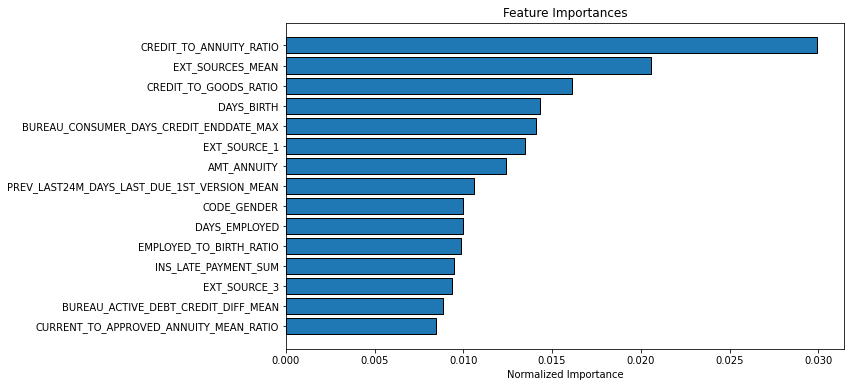

In [ ]:
fi_sorted = plot_feature_importances(fi)